<a href="https://colab.research.google.com/github/albogdan/aps360-project/blob/master/CNN_baseline_models/CNN/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchsummary import summary
import os
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
if os.path.exists(os.path.expanduser('~/data')):
  !rm -rf {os.path.expanduser('~/data')}
!unzip '/content/drive/My Drive/APS360 Project/kaggle_dataset/separate_dataset.zip' -d {os.path.expanduser('~/data')}

In [4]:
classes = os.listdir(os.path.expanduser('~/data/separate_dataset'))
classes.sort()
classes = classes[1:]
print(classes)

['14719', '15672', '18654', '2357', '2420', '2780', '27925', '3001', '3002', '3003', '3004', '3005', '3010', '3020', '3021', '3022', '3023', '3024', '3037', '3038', '3039', '3040', '3045', '3046', '3062', '3063', '3068', '3069', '3070', '3298', '33909', '3622', '3623', '3659', '3675', '3700', '3794', '4150', '41677', '41678', '4274', '4286', '43093', '43857', '4490', '54200', '6143', '6632', '85984', '99301']


In [5]:
# Transform Settings - resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.Resize((224,224)), 
                                     transforms.ToTensor()])

# define dataloader parameters
num_workers = 4
batch_size = 32

# get dataset
image_set = datasets.ImageFolder(os.path.expanduser('~/data/separate_dataset'), transform=data_transform)

In [6]:
# function to load features
def image_loader(dataset, train_p, val_p, batch_size = 32):
  split = [int(train_p * len(dataset)), int(val_p * len(dataset))]
  split.append(len(dataset) - split[1] - split[0])

  train_set, val_set, test_set = torch.utils.data.random_split(dataset, split)
  num_workers = 4

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  return train_loader, val_loader, test_loader

#Architecture

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
net = Autoencoder()
summary(net, (1,224,224),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             160
              ReLU-2         [-1, 16, 112, 112]               0
            Conv2d-3           [-1, 32, 56, 56]           4,640
              ReLU-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 50, 50]         100,416
   ConvTranspose2d-6           [-1, 32, 56, 56]         100,384
              ReLU-7           [-1, 32, 56, 56]               0
   ConvTranspose2d-8         [-1, 16, 112, 112]           4,624
              ReLU-9         [-1, 16, 112, 112]               0
  ConvTranspose2d-10          [-1, 1, 224, 224]             145
          Sigmoid-11          [-1, 1, 224, 224]               0
Total params: 210,369
Trainable params: 210,369
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/

#Training Code

In [ ]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3, wd = 1e-5):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=wd) # <-- 
    train_loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size,
                                             num_workers = 4, shuffle = True)
    outputs = []
    start_time = time.time()
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            if torch.cuda.is_available():
              img = img.cuda()
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

#Training

In [ ]:
print(torch.cuda.device_count())

1


In [ ]:
model = Autoencoder().cuda()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs, batch_size=500)

Epoch 0 Finished.  Time per Epoch:  151.95 s 
Epoch:1, Loss:0.0032
Epoch 1 Finished.  Time per Epoch:  151.79 s 
Epoch:2, Loss:0.0014
Epoch 2 Finished.  Time per Epoch:  151.55 s 
Epoch:3, Loss:0.0008
Epoch 3 Finished.  Time per Epoch:  151.95 s 
Epoch:4, Loss:0.0006
Epoch 4 Finished.  Time per Epoch:  152.67 s 
Epoch:5, Loss:0.0004
Epoch 5 Finished.  Time per Epoch:  152.95 s 
Epoch:6, Loss:0.0003
Epoch 6 Finished.  Time per Epoch:  152.93 s 
Epoch:7, Loss:0.0003
Epoch 7 Finished.  Time per Epoch:  152.82 s 
Epoch:8, Loss:0.0003
Epoch 8 Finished.  Time per Epoch:  152.45 s 
Epoch:9, Loss:0.0003
Epoch 9 Finished.  Time per Epoch:  152.66 s 
Epoch:10, Loss:0.0002
Epoch 10 Finished.  Time per Epoch:  153.05 s 
Epoch:11, Loss:0.0002
Epoch 11 Finished.  Time per Epoch:  153.36 s 
Epoch:12, Loss:0.0002
Epoch 12 Finished.  Time per Epoch:  153.25 s 
Epoch:13, Loss:0.0002
Epoch 13 Finished.  Time per Epoch:  153.51 s 
Epoch:14, Loss:0.0002
Epoch 14 Finished.  Time per Epoch:  153.71 s 
Epoch:

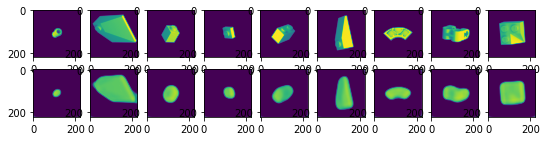

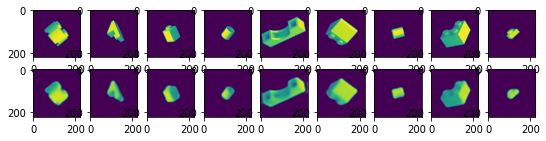

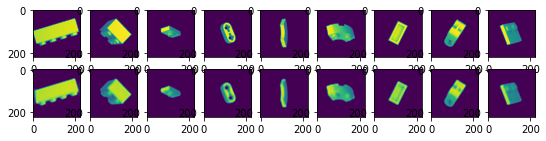

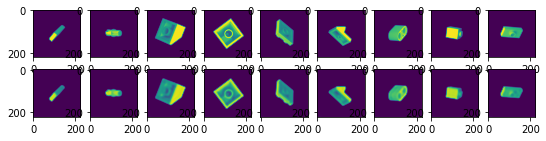

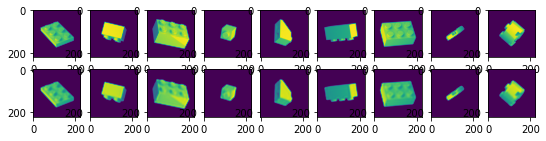

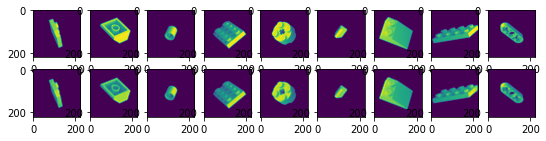

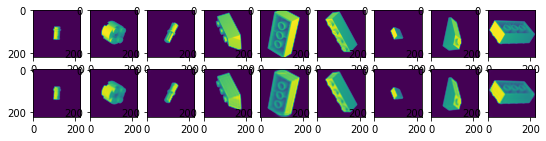

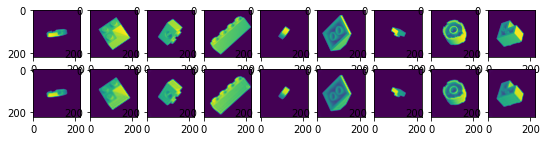

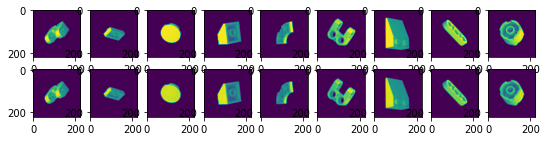

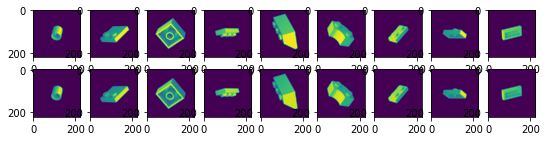

In [ ]:
for k in range(0, max_epochs, 2):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

#Saving Model

In [ ]:
torch.save(model.state_dict(), os.path.expanduser('~/models/AutoEncoder/no_noise.pt'))

In [ ]:
embedding_root_path = os.path.expanduser('~/embedding')
for i in classes:
  path = os.path.join(embedding_root_path, i)
  if not os.path.exists(path):
    !mkdir -p {path}

In [ ]:
loader = torch.utils.data.DataLoader(image_set, batch_size=1, 
                                        num_workers=4, shuffle=False)
for img, label in loader:
  img = img.cuda()
  embedding = model.encoder(img)
  print(embedding.shape)
  break

torch.Size([1, 64, 50, 50])


In [ ]:
# generate and save embedding
i = 0
loader = torch.utils.data.DataLoader(image_set, batch_size=1, 
                                        num_workers=4, shuffle=False)
for img, label in loader:
  img = img.cuda()
  embedding = model.encoder(img).cpu()
  embedding_tensor = torch.from_numpy(embedding.detach().numpy())
  embedding_folder_path = os.path.join(embedding_root_path, classes[label])
  embedding_path = os.path.join(embedding_folder_path, "{}.tensor".format(i))
  torch.save(embedding_tensor.squeeze(0), embedding_path)
  i += 1
  print("saved {} images".format(i))

Streaming output truncated to the last 5000 lines.
saved 35002 images
saved 35003 images
saved 35004 images
saved 35005 images
saved 35006 images
saved 35007 images
saved 35008 images
saved 35009 images
saved 35010 images
saved 35011 images
saved 35012 images
saved 35013 images
saved 35014 images
saved 35015 images
saved 35016 images
saved 35017 images
saved 35018 images
saved 35019 images
saved 35020 images
saved 35021 images
saved 35022 images
saved 35023 images
saved 35024 images
saved 35025 images
saved 35026 images
saved 35027 images
saved 35028 images
saved 35029 images
saved 35030 images
saved 35031 images
saved 35032 images
saved 35033 images
saved 35034 images
saved 35035 images
saved 35036 images
saved 35037 images
saved 35038 images
saved 35039 images
saved 35040 images
saved 35041 images
saved 35042 images
saved 35043 images
saved 35044 images
saved 35045 images
saved 35046 images
saved 35047 images
saved 35048 images
saved 35049 images
saved 35050 images
saved 35051 images

In [ ]:
!zip embedding.zip -r {embedding_root_path}

Streaming output truncated to the last 5000 lines.
  adding: root/embedding/43857/35118.tensor (deflated 69%)
  adding: root/embedding/43857/34715.tensor (deflated 78%)
  adding: root/embedding/43857/34669.tensor (deflated 77%)
  adding: root/embedding/43857/34637.tensor (deflated 75%)
  adding: root/embedding/43857/35007.tensor (deflated 76%)
  adding: root/embedding/43857/34537.tensor (deflated 73%)
  adding: root/embedding/43857/34717.tensor (deflated 75%)
  adding: root/embedding/43857/34885.tensor (deflated 73%)
  adding: root/embedding/43857/34946.tensor (deflated 73%)
  adding: root/embedding/43857/34881.tensor (deflated 76%)
  adding: root/embedding/43857/34618.tensor (deflated 72%)
  adding: root/embedding/43857/35169.tensor (deflated 74%)
  adding: root/embedding/43857/34967.tensor (deflated 75%)
  adding: root/embedding/43857/35074.tensor (deflated 71%)
  adding: root/embedding/43857/34413.tensor (deflated 73%)
  adding: root/embedding/43857/34822.tensor (deflated 71%)
  add

#Classifier

In [ ]:
# function to load features
def embedding_loader(embedding_root_path, train_p, val_p, batch_size = 32):
  dataset = torchvision.datasets.DatasetFolder(embedding_root_path,\
                                                 loader = torch.load, extensions = ('.tensor'))

  split = [int(train_p * len(dataset)), int(val_p * len(dataset))]
  split.append(len(dataset) - split[1] - split[0])

  train_set, val_set, test_set = torch.utils.data.random_split(dataset, split)
  num_workers = 4

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  return train_loader, val_loader, test_loader

In [ ]:
class EmbeddingANN(nn.Module):
  def __init__(self):
    super(EmbeddingANN, self).__init__()
    self.name = "EmANN"
    self.fc1 = nn.Linear(64*50*50, 10000)
    self.fc2 = nn.Linear(10000, 1200)
    self.fc3 = nn.Linear(1200, 50)
  
  def forward(self, x):
    x = x.view(-1, 64*50*50)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    return x

EmANNet = EmbeddingANN()
summary(EmANNet, (64,50,50), device='cpu')

#Training with Noise

In [ ]:
def train_noise(model, num_epochs=5, batch_size=64, learning_rate=1e-3, noise = 0):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <-- 
    train_loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size,
                                             num_workers = 4, shuffle = True)
    outputs = []
    start_time = time.time()
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img_noisy = img + noise * torch.randn(*img.shape)
            img_noisy = np.clip(img_noisy, 0., 1.)
            if torch.cuda.is_available():
              img_noisy = img_noisy.cuda()
              img = img.cuda()
            recon = model(img_noisy)
            # recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [ ]:
model_2 = Autoencoder().cuda()
max_epochs = 20
outputs = train_noise(model_2, num_epochs=max_epochs, batch_size=300, learning_rate=1e-3, noise = 1e-3)

Epoch 0 Finished.  Time per Epoch:  172.10 s 
Epoch:1, Loss:0.0021
Epoch 1 Finished.  Time per Epoch:  172.37 s 
Epoch:2, Loss:0.0006
Epoch 2 Finished.  Time per Epoch:  172.74 s 
Epoch:3, Loss:0.0004
Epoch 3 Finished.  Time per Epoch:  173.07 s 
Epoch:4, Loss:0.0003
Epoch 4 Finished.  Time per Epoch:  173.45 s 
Epoch:5, Loss:0.0002
Epoch 5 Finished.  Time per Epoch:  173.66 s 
Epoch:6, Loss:0.0002
Epoch 6 Finished.  Time per Epoch:  173.81 s 
Epoch:7, Loss:0.0002
Epoch 7 Finished.  Time per Epoch:  173.83 s 
Epoch:8, Loss:0.0002
Epoch 8 Finished.  Time per Epoch:  173.81 s 
Epoch:9, Loss:0.0002
Epoch 9 Finished.  Time per Epoch:  173.76 s 
Epoch:10, Loss:0.0002
Epoch 10 Finished.  Time per Epoch:  173.75 s 
Epoch:11, Loss:0.0002
Epoch 11 Finished.  Time per Epoch:  173.73 s 
Epoch:12, Loss:0.0002
Epoch 12 Finished.  Time per Epoch:  173.72 s 
Epoch:13, Loss:0.0001
Epoch 13 Finished.  Time per Epoch:  173.70 s 
Epoch:14, Loss:0.0001
Epoch 14 Finished.  Time per Epoch:  173.70 s 
Epoch:

In [ ]:
torch.save(model_2.state_dict(), os.pacth.expanduser('~/noise1'))

NameError: ignored

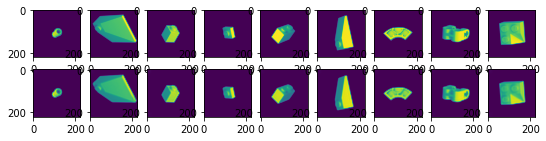

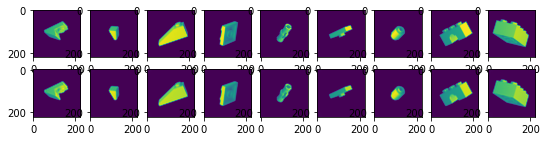

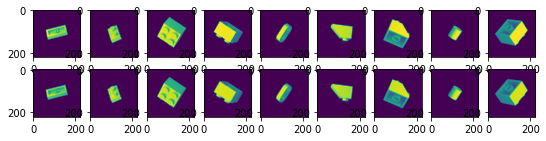

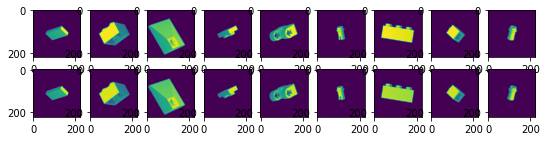

In [ ]:
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [ ]:
torch.cuda.empty_cache()
model_3 = Autoencoder()
model_3 = model_3.cuda()
max_epochs = 20
outputs_temp = train_noise(model_3, num_epochs=max_epochs, batch_size=500, learning_rate=1e-3, noise = 3e-3)

Epoch 0 Finished.  Time per Epoch:  169.54 s 
Epoch:1, Loss:0.0300
Epoch 1 Finished.  Time per Epoch:  169.66 s 
Epoch:2, Loss:0.0306
Epoch 2 Finished.  Time per Epoch:  169.68 s 
Epoch:3, Loss:0.0310
Epoch 3 Finished.  Time per Epoch:  169.73 s 
Epoch:4, Loss:0.0294
Epoch 4 Finished.  Time per Epoch:  169.79 s 
Epoch:5, Loss:0.0312


KeyboardInterrupt: ignored

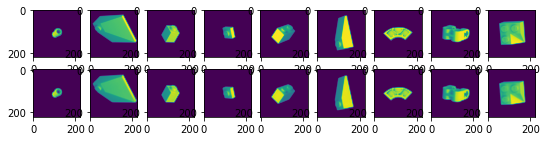

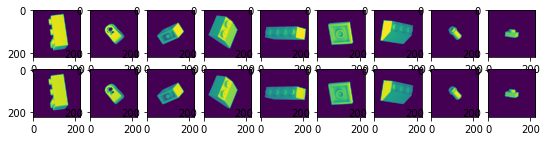

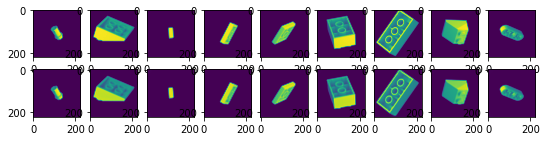

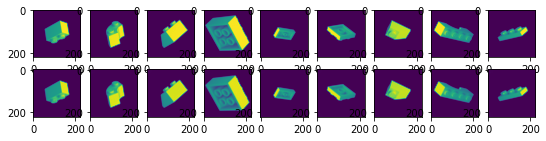

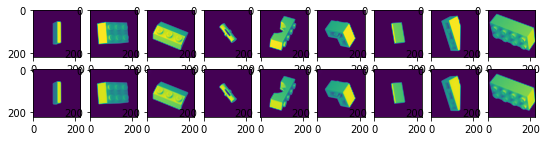

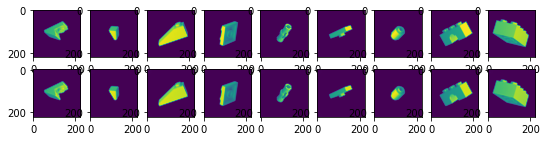

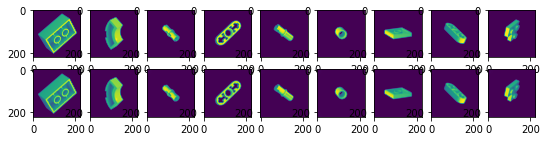

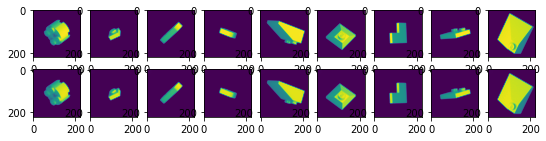

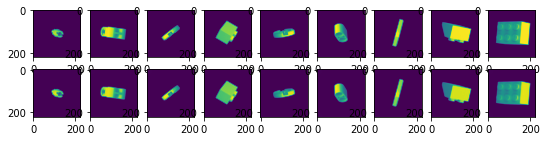

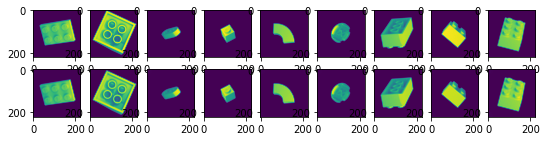

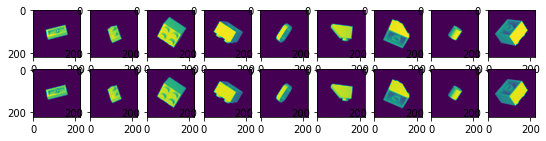

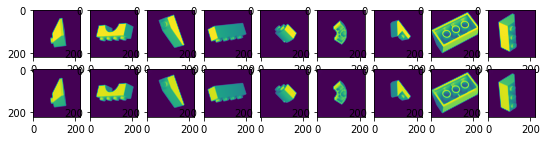

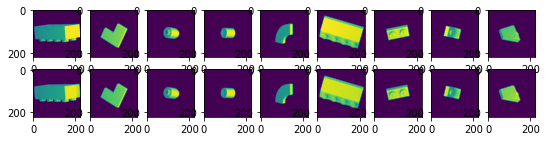

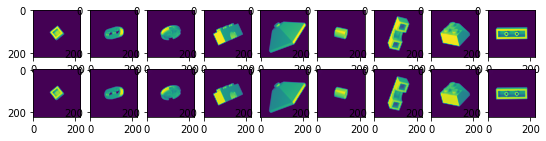

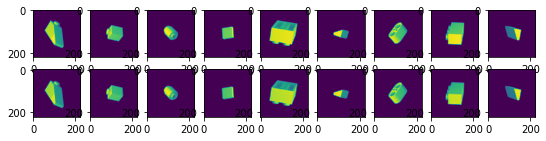

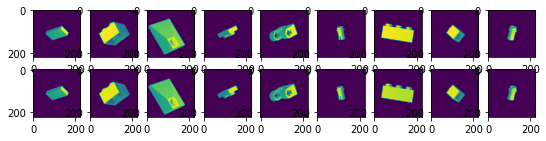

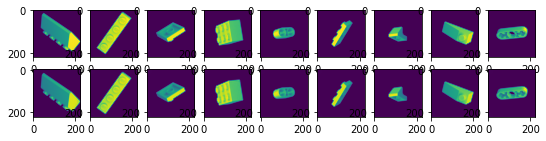

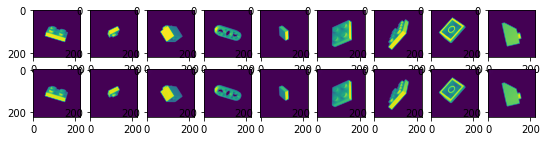

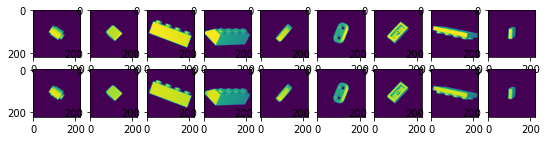

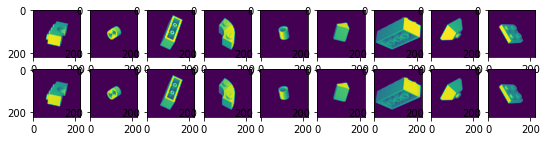

In [ ]:
for k in range(0, max_epochs, 1):
    plt.figure(figsize=(9, 2))
    imgs = outputs_temp[k][1].detach().cpu().numpy()
    recon = outputs_temp[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

# Trying with a Smaller Architecture

In [ ]:
class AutoencoderSmall(nn.Module):
    def __init__(self):
        super(AutoencoderSmall, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.Conv2d(8, 16, 5, stride=2, padding=1),
            nn.Conv2d(16, 32, 5, stride=2, padding=1),
            nn.Conv2d(32, 64, 5, stride=2, padding=1),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 5, stride=2, padding = 1),
            nn.ConvTranspose2d(32, 16, 5, stride=2, padding = 1),
            nn.ConvTranspose2d(16, 8, 5, stride=2, padding = 1, output_padding=1),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding = 1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
net = AutoencoderSmall()
summary(net, (1,224,224),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]              80
            Conv2d-2           [-1, 16, 55, 55]           3,216
            Conv2d-3           [-1, 32, 27, 27]          12,832
            Conv2d-4           [-1, 64, 13, 13]          51,264
   ConvTranspose2d-5           [-1, 32, 27, 27]          51,232
   ConvTranspose2d-6           [-1, 16, 55, 55]          12,816
   ConvTranspose2d-7          [-1, 8, 112, 112]           3,208
   ConvTranspose2d-8          [-1, 1, 224, 224]              73
           Sigmoid-9          [-1, 1, 224, 224]               0
Total params: 134,721
Trainable params: 134,721
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 3.47
Params size (MB): 0.51
Estimated Total Size (MB): 4.18
-------------------------------------------

In [ ]:
model = AutoencoderSmall().cuda()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs, batch_size=500)

Epoch 0 Finished.  Time per Epoch:  114.64 s 
Epoch:1, Loss:0.0262
Epoch 1 Finished.  Time per Epoch:  113.29 s 
Epoch:2, Loss:0.0070
Epoch 2 Finished.  Time per Epoch:  112.37 s 
Epoch:3, Loss:0.0201
Epoch 3 Finished.  Time per Epoch:  111.60 s 
Epoch:4, Loss:0.0050
Epoch 4 Finished.  Time per Epoch:  110.92 s 
Epoch:5, Loss:0.0034
Epoch 5 Finished.  Time per Epoch:  110.54 s 
Epoch:6, Loss:0.0030
Epoch 6 Finished.  Time per Epoch:  110.64 s 
Epoch:7, Loss:0.0030
Epoch 7 Finished.  Time per Epoch:  110.39 s 
Epoch:8, Loss:0.0028
Epoch 8 Finished.  Time per Epoch:  110.14 s 
Epoch:9, Loss:0.0028
Epoch 9 Finished.  Time per Epoch:  109.82 s 
Epoch:10, Loss:0.0027
Epoch 10 Finished.  Time per Epoch:  109.66 s 
Epoch:11, Loss:0.0027
Epoch 11 Finished.  Time per Epoch:  109.53 s 
Epoch:12, Loss:0.0026
Epoch 12 Finished.  Time per Epoch:  109.44 s 
Epoch:13, Loss:0.0024
Epoch 13 Finished.  Time per Epoch:  109.54 s 
Epoch:14, Loss:0.0023
Epoch 14 Finished.  Time per Epoch:  109.58 s 
Epoch:

In [ ]:
torch.save(model.state_dict(), os.path.expanduser('~/models/AutoEncoder/small_no_noise.pt'))

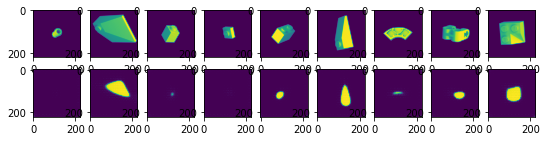

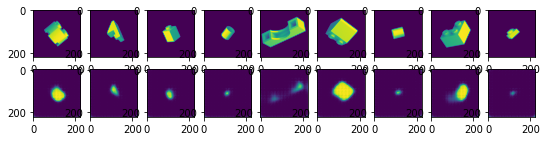

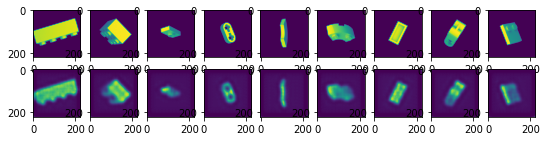

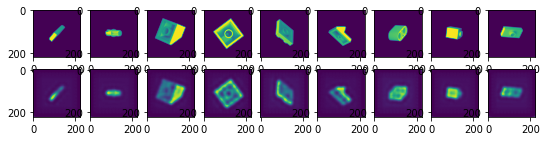

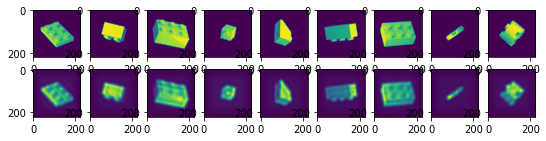

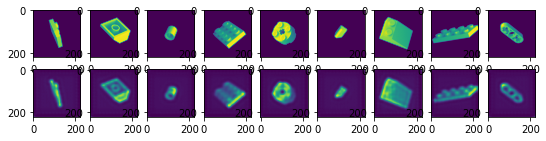

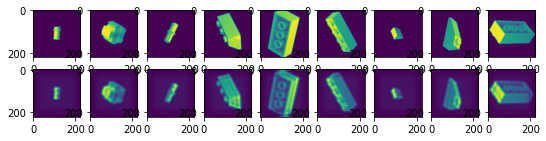

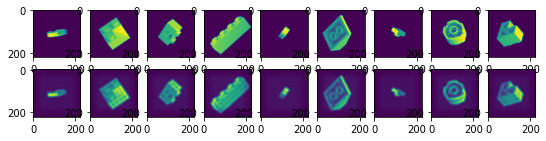

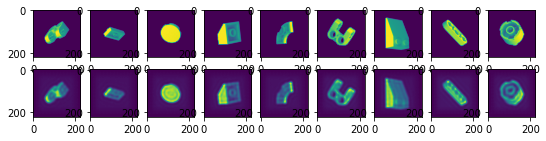

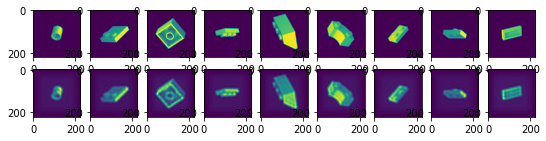

In [ ]:
for k in range(0, max_epochs, 2):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [ ]:
model_2 = AutoencoderSmall().cuda()
max_epochs = 20
outputs_2 = train(model_2, num_epochs=max_epochs, batch_size=500)

Epoch 0 Finished.  Time per Epoch:  104.82 s 
Epoch:1, Loss:0.0260
Epoch 1 Finished.  Time per Epoch:  104.79 s 
Epoch:2, Loss:0.0290
Epoch 2 Finished.  Time per Epoch:  104.76 s 
Epoch:3, Loss:0.0275
Epoch 3 Finished.  Time per Epoch:  104.77 s 
Epoch:4, Loss:0.0066
Epoch 4 Finished.  Time per Epoch:  104.69 s 
Epoch:5, Loss:0.0044
Epoch 5 Finished.  Time per Epoch:  104.61 s 
Epoch:6, Loss:0.0035
Epoch 6 Finished.  Time per Epoch:  104.67 s 
Epoch:7, Loss:0.0033
Epoch 7 Finished.  Time per Epoch:  104.68 s 
Epoch:8, Loss:0.0031
Epoch 8 Finished.  Time per Epoch:  104.72 s 
Epoch:9, Loss:0.0028
Epoch 9 Finished.  Time per Epoch:  104.74 s 
Epoch:10, Loss:0.0027


RuntimeError: ignored

In [ ]:
loaded_model = AutoencoderSmall().cuda()
loaded_model.load_state_dict(torch.load(os.path.expanduser('~/models/AutoEncoder/small_no_noise.pt')))
loaded_model.eval()

AutoencoderSmall(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): Sigmoid()
  )
)

In [ ]:
# turn off gradient just to be safe
for l in loaded_model.encoder:
  for p in l.parameters():
    p.requires_grad = False

In [ ]:
# verify that the parameters are loaded correctly
train_loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size,
                                             num_workers = 4, shuffle = True)
criterion = nn.MSELoss()
for data in train_loader:
  img, _ = data
  if torch.cuda.is_available():
    img = img.cuda()
  recon = loaded_model(img)
  loss = criterion(recon, img)
  print(loss)
  break

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward>)


# Training classifier with autoencoder embedding

In [7]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(model, aEncoder, loader, criterion):
  total_loss = 0.0
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(loader, 0):
      imgs, labels = data
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      embedding = aEncoder.encoder(imgs)
      output = model(embedding)

      # select index with maximum prediction score
      pred = output.max(1, keepdim = True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
      total_loss += criterion(output, labels).item()
  return 1 - correct/total, total_loss

def plot_training_curve(path):
  """ Plots the training curve for a model run, given the csv files
  containing the train/validation error/loss.

  Args:
      path: The base path of the csv files produced during training
  """
  import matplotlib.pyplot as plt
  train_err = np.loadtxt("{}_train_err.csv".format(path))
  val_err = np.loadtxt("{}_val_err.csv".format(path))
  train_loss = np.loadtxt("{}_train_loss.csv".format(path))
  val_loss = np.loadtxt("{}_val_loss.csv".format(path))
  plt.title("Train vs Validation Error")
  n = len(train_err) # number of epochs
  plt.plot(range(1,n+1), train_err, label="Train")
  plt.plot(range(1,n+1), val_err, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Error")
  plt.legend(loc='best')
  plt.show()
  plt.title("Train vs Validation Loss")
  plt.plot(range(1,n+1), train_loss, label="Train")
  plt.plot(range(1,n+1), val_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

In [9]:
def autoencoder_classifier_train(model, aEncoder, batch_size = 32, num_epochs = 10, lr = 0.003, wd = 1e-5):
  torch.manual_seed(360)

  train_loader, val_loader, test_loader = image_loader(image_set, 0.6, 0.2, batch_size)

  # Initialize containers for error and loss
  train_err, train_loss, val_err, val_loss = [], [], [], []

  # set up optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = lr, 
                                 weight_decay=wd)

  start_time = time.time()

  for epoch in range(num_epochs):
    epoch_total = 0
    epoch_correct = 0
    epoch_loss = 0
    model.train()
    for image, labels in iter(train_loader):

      # Enable GPU
      if use_cuda and torch.cuda.is_available():
        image = image.cuda()
        labels = labels.cuda()
      
      # zero parameter gradients
      optimizer.zero_grad()

      # forward pass, backward pass, and optimize
      embedding = aEncoder.encoder(image)
      out = model(embedding)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()
      
      # mini batch statistics
      pred = out.max(1, keepdim = True)[1]
      epoch_correct += pred.eq(labels.view_as(pred)).sum().item()
      epoch_total += image.shape[0]
      epoch_loss += loss.item()
    train_err.append(1 - (epoch_correct / epoch_total))
    train_loss.append(epoch_loss)
    a, b = evaluate(model, aEncoder, val_loader, criterion)
    val_err.append(a)
    val_loss.append(b)
    
    print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
    print ("train err: {:.4f}, train loss: {:.4f}".format(train_err[epoch], train_loss[epoch]))
    print ("validation err: {:.4f}, validation loss: {:.4f}".format(a, b))

    # save the current model state
    if (train_err[-1] < 0.15):
      model_path = get_model_name(model.name, batch_size, lr, epoch)
      torch.save(model.state_dict(), model_path)
  
  print('Finished training in %6.2f s' % (time.time()-start_time))
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


In [ ]:
class AutoEncoderClassifier(nn.Module):
  def __init__(self):
    super(AutoEncoderClassifier, self).__init__()
    self.name = "AutoEncoderClassifier"
    self.fc1 = nn.Linear(64*13*13, 512)
    self.fc2 = nn.Linear(512, 50)
  
  def forward(self, x):
    x = x.view(-1, 64*13*13)
    x = F.leaky_relu(self.fc1(x))
    x = self.fc2(x)
    return x

AECNet = AutoEncoderClassifier()
summary(AECNet, (64,13,13), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       5,538,304
            Linear-2                   [-1, 50]          25,650
Total params: 5,563,954
Trainable params: 5,563,954
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.00
Params size (MB): 21.22
Estimated Total Size (MB): 21.27
----------------------------------------------------------------


In [ ]:
# training with the initial set up
use_cuda = True
AECNet = AutoEncoderClassifier().cuda()
autoencoder_classifier_train(AECNet, loaded_model, batch_size=500, num_epochs=30, lr=0.001)

Epoch 0 Finished.  Time per Epoch:  86.11 s 
train err: 0.9347, train loss: 708.4837
validation err: 0.8694, validation loss: 53.1108
Epoch 1 Finished.  Time per Epoch:  85.94 s 
train err: 0.7928, train loss: 130.0632
validation err: 0.7299, validation loss: 38.2601
Epoch 2 Finished.  Time per Epoch:  85.90 s 
train err: 0.6986, train loss: 108.0006
validation err: 0.6971, validation loss: 35.6328
Epoch 3 Finished.  Time per Epoch:  85.87 s 
train err: 0.6643, train loss: 101.4660
validation err: 0.6925, validation loss: 34.5396
Epoch 4 Finished.  Time per Epoch:  85.85 s 
train err: 0.6413, train loss: 97.6281
validation err: 0.6635, validation loss: 33.4692
Epoch 5 Finished.  Time per Epoch:  85.78 s 
train err: 0.6165, train loss: 93.3035
validation err: 0.6434, validation loss: 32.4326
Epoch 6 Finished.  Time per Epoch:  85.76 s 
train err: 0.6102, train loss: 91.4737
validation err: 0.6361, validation loss: 31.6459
Epoch 7 Finished.  Time per Epoch:  85.72 s 
train err: 0.6043, t

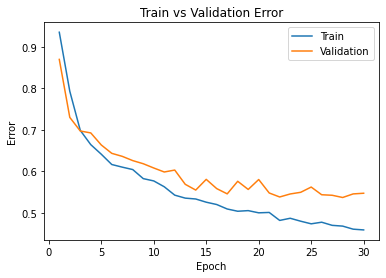

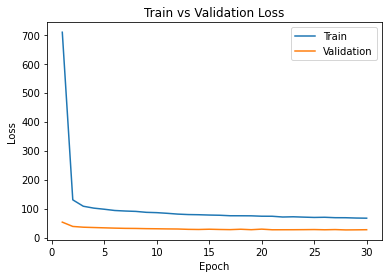

In [ ]:
plot_training_curve(get_model_name(AECNet.name, 500, 0.001, 29))

In [ ]:
# training with the initial set up
use_cuda = True
AECNet2 = AutoEncoderClassifier().cuda()
autoencoder_classifier_train(AECNet2, loaded_model, batch_size=500, num_epochs=500, lr=0.001)

Epoch 0 Finished.  Time per Epoch:  87.40 s 
train err: 0.9304, train loss: 849.2127
validation err: 0.8906, validation loss: 55.4487
Epoch 1 Finished.  Time per Epoch:  87.19 s 
train err: 0.7879, train loss: 132.4404
validation err: 0.7289, validation loss: 38.8465
Epoch 2 Finished.  Time per Epoch:  86.85 s 
train err: 0.6996, train loss: 109.5795
validation err: 0.7100, validation loss: 36.4701
Epoch 3 Finished.  Time per Epoch:  86.41 s 
train err: 0.6725, train loss: 102.7427
validation err: 0.6665, validation loss: 34.2013
Epoch 4 Finished.  Time per Epoch:  85.79 s 
train err: 0.6435, train loss: 98.2166
validation err: 0.6675, validation loss: 33.6590
Epoch 5 Finished.  Time per Epoch:  85.17 s 
train err: 0.6244, train loss: 94.2969
validation err: 0.6678, validation loss: 32.5869
Epoch 6 Finished.  Time per Epoch:  84.67 s 
train err: 0.6210, train loss: 92.7151
validation err: 0.6452, validation loss: 32.1943
Epoch 7 Finished.  Time per Epoch:  84.24 s 
train err: 0.6132, t

In [ ]:
plot_training_curve(get_model_name(AECNet2.name, 500, 0.001, 499))

NameError: ignored

In [ ]:
class AutoEncoderClassifier2(nn.Module):
  def __init__(self):
    super(AutoEncoderClassifier2, self).__init__()
    self.name = "AutoEncoderClassifier2"
    self.fc1 = nn.Linear(64*13*13, 2048)
    self.fc2 = nn.Linear(2048, 256)
    self.fc3 = nn.Linear(256, 50)
  
  def forward(self, x):
    x = x.view(-1, 64*13*13)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    return x

AECNet3 = AutoEncoderClassifier2()
summary(AECNet3, (64,13,13), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]      22,153,216
            Linear-2                  [-1, 256]         524,544
            Linear-3                   [-1, 50]          12,850
Total params: 22,690,610
Trainable params: 22,690,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.02
Params size (MB): 86.56
Estimated Total Size (MB): 86.62
----------------------------------------------------------------


In [ ]:
# training with the initial set up
use_cuda = True
AECNet3 = AutoEncoderClassifier2().cuda()
autoencoder_classifier_train(AECNet3, loaded_model, batch_size=500, num_epochs=50, lr=0.003)

Epoch 0 Finished.  Time per Epoch:  91.91 s 
train err: 0.9660, train loss: 1959.4254
validation err: 0.9525, validation loss: 63.3020
Epoch 1 Finished.  Time per Epoch:  92.43 s 
train err: 0.9428, train loss: 179.1369
validation err: 0.9173, validation loss: 56.4133
Epoch 2 Finished.  Time per Epoch:  92.04 s 
train err: 0.8700, train loss: 150.7534
validation err: 0.8282, validation loss: 46.5468
Epoch 3 Finished.  Time per Epoch:  92.09 s 
train err: 0.8233, train loss: 136.1746
validation err: 0.7829, validation loss: 41.8805
Epoch 4 Finished.  Time per Epoch:  92.07 s 
train err: 0.7595, train loss: 120.8655
validation err: 0.7544, validation loss: 39.3423
Epoch 5 Finished.  Time per Epoch:  92.12 s 
train err: 0.7282, train loss: 113.0115
validation err: 0.7245, validation loss: 37.1265
Epoch 6 Finished.  Time per Epoch:  92.22 s 
train err: 0.7028, train loss: 107.7122
validation err: 0.7303, validation loss: 36.5765
Epoch 7 Finished.  Time per Epoch:  92.25 s 
train err: 0.690

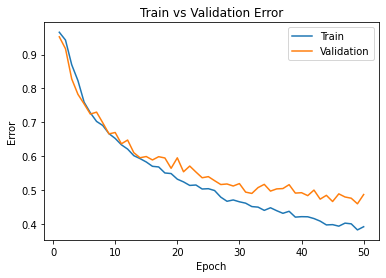

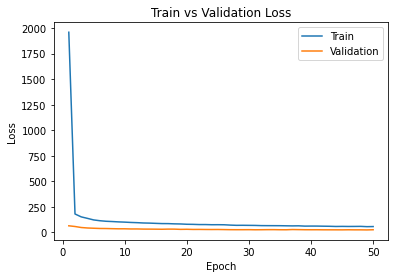

In [ ]:
plot_training_curve(get_model_name(AECNet3.name, 500, 0.003, 49))

# Training classifier with larger autoencoder


In [ ]:
loaded_model_large = Autoencoder().cuda()
loaded_model_large.load_state_dict(torch.load(os.path.expanduser('~/models/AutoEncoder/no_noise.pt')))
loaded_model_large.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [ ]:
# turn off gradient just to be safe
for l in loaded_model_large.encoder:
  for p in l.parameters():
    p.requires_grad = False

In [ ]:
# verify that the parameters are loaded correctly
train_loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size,
                                             num_workers = 4, shuffle = True)
criterion = nn.MSELoss()
for data in train_loader:
  img, _ = data
  if torch.cuda.is_available():
    img = img.cuda()
  recon = loaded_model_large(img)
  loss = criterion(recon, img)
  print(loss)
  break

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


In [ ]:
class AutoEncoderClassifier3(nn.Module):
  def __init__(self):
    super(AutoEncoderClassifier3, self).__init__()
    self.name = "AutoEncoderClassifier3"
    self.fc1 = nn.Linear(64*50*50, 8192)
    self.fc2 = nn.Linear(8192, 50)
  
  def forward(self, x):
    x = x.view(-1, 64*50*50)
    x = F.leaky_relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
AECNet4 = AutoEncoderClassifier3()
summary(AECNet4, (64,50,50), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]   1,310,728,192
            Linear-2                   [-1, 50]         409,650
Total params: 1,311,137,842
Trainable params: 1,311,137,842
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.61
Forward/backward pass size (MB): 0.06
Params size (MB): 5001.59
Estimated Total Size (MB): 5002.27
----------------------------------------------------------------


In [ ]:
del AECNet4

In [ ]:
# training with the initial set up
use_cuda = True
AECNet4 = AutoEncoderClassifier3().cuda()
autoencoder_classifier_train(AECNet4, loaded_model_large, batch_size=500, num_epochs=30, lr=0.001)

RuntimeError: ignored

In [ ]:
plot_training_curve(get_model_name(AECNet4.name, 500, 0.003, 29))

# Medium sized autoencoder

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [10]:
class AutoencoderMedium(nn.Module):
    def __init__(self):
        super(AutoencoderMedium, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.Conv2d(16, 32, 3, stride=3, padding=1),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.Conv2d(64, 256, 3, stride=2, padding=1),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 3, stride=2, padding = 1),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding = 1, output_padding=1),
            nn.ConvTranspose2d(32, 16, 3, stride=3, padding = 1),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding = 1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
net = AutoencoderMedium()
summary(net, (1,224,224),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             160
            Conv2d-2           [-1, 32, 38, 38]           4,640
            Conv2d-3           [-1, 64, 19, 19]          18,496
            Conv2d-4          [-1, 256, 10, 10]         147,712
   ConvTranspose2d-5           [-1, 64, 19, 19]         147,520
   ConvTranspose2d-6           [-1, 32, 38, 38]          18,464
   ConvTranspose2d-7         [-1, 16, 112, 112]           4,624
   ConvTranspose2d-8          [-1, 1, 224, 224]             145
           Sigmoid-9          [-1, 1, 224, 224]               0
Total params: 341,761
Trainable params: 341,761
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 5.08
Params size (MB): 1.30
Estimated Total Size (MB): 6.58
-------------------------------------------

In [ ]:
model = AutoencoderMedium().cuda()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs, batch_size=500)

Epoch 0 Finished.  Time per Epoch:  106.69 s 
Epoch:1, Loss:0.0300
Epoch 1 Finished.  Time per Epoch:  106.31 s 
Epoch:2, Loss:0.0315
Epoch 2 Finished.  Time per Epoch:  106.71 s 
Epoch:3, Loss:0.0316
Epoch 3 Finished.  Time per Epoch:  106.49 s 
Epoch:4, Loss:0.0057
Epoch 4 Finished.  Time per Epoch:  106.23 s 
Epoch:5, Loss:0.0036
Epoch 5 Finished.  Time per Epoch:  106.14 s 
Epoch:6, Loss:0.0030
Epoch 6 Finished.  Time per Epoch:  106.04 s 
Epoch:7, Loss:0.0029
Epoch 7 Finished.  Time per Epoch:  105.93 s 
Epoch:8, Loss:0.0026
Epoch 8 Finished.  Time per Epoch:  105.91 s 
Epoch:9, Loss:0.0025
Epoch 9 Finished.  Time per Epoch:  105.88 s 
Epoch:10, Loss:0.0024
Epoch 10 Finished.  Time per Epoch:  105.81 s 
Epoch:11, Loss:0.0023
Epoch 11 Finished.  Time per Epoch:  105.74 s 
Epoch:12, Loss:0.0022
Epoch 12 Finished.  Time per Epoch:  105.66 s 
Epoch:13, Loss:0.0022
Epoch 13 Finished.  Time per Epoch:  105.58 s 
Epoch:14, Loss:0.0021
Epoch 14 Finished.  Time per Epoch:  105.54 s 
Epoch:

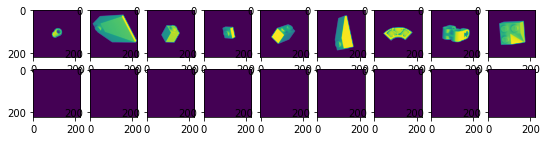

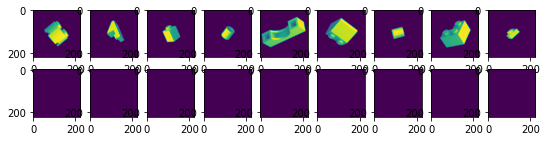

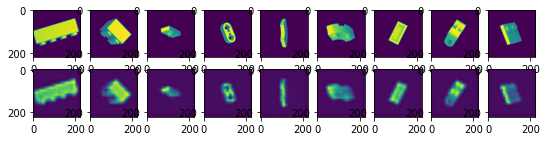

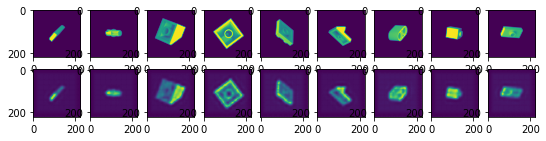

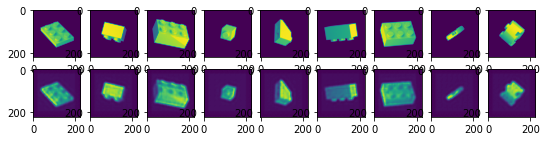

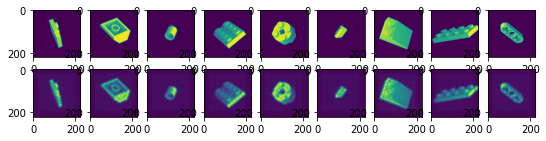

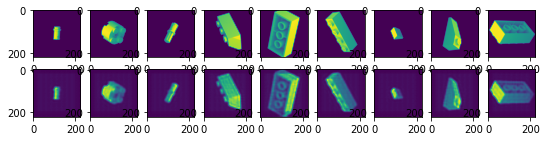

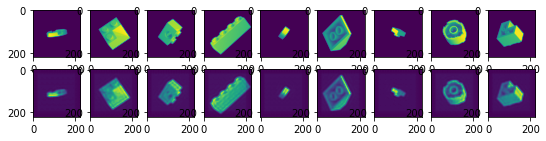

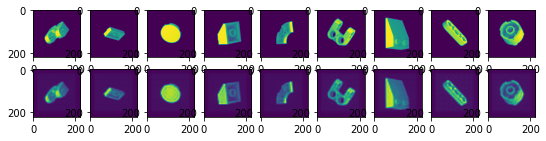

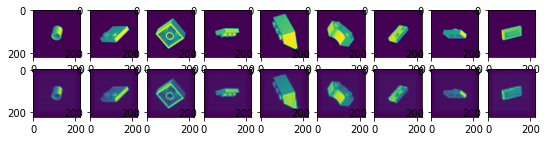

In [ ]:
for k in range(0, max_epochs, 2):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [ ]:
torch.save(model.state_dict(), os.path.expanduser('~/models/AutoEncoder/medium_no_noise.pt'))

In [ ]:
model_2 = AutoencoderMedium().cuda()
max_epochs = 20
outputs_noise = train_noise(model_2, num_epochs=max_epochs, batch_size=500, learning_rate=1e-3, noise = 1e-4)

Epoch 0 Finished.  Time per Epoch:  134.67 s 
Epoch:1, Loss:0.0048
Epoch 1 Finished.  Time per Epoch:  135.01 s 
Epoch:2, Loss:0.0037
Epoch 2 Finished.  Time per Epoch:  135.05 s 
Epoch:3, Loss:0.0034
Epoch 3 Finished.  Time per Epoch:  135.06 s 
Epoch:4, Loss:0.0030
Epoch 4 Finished.  Time per Epoch:  135.28 s 
Epoch:5, Loss:0.0029
Epoch 5 Finished.  Time per Epoch:  135.44 s 
Epoch:6, Loss:0.0025
Epoch 6 Finished.  Time per Epoch:  135.53 s 
Epoch:7, Loss:0.0024
Epoch 7 Finished.  Time per Epoch:  135.55 s 
Epoch:8, Loss:0.0024
Epoch 8 Finished.  Time per Epoch:  135.63 s 
Epoch:9, Loss:0.0023
Epoch 9 Finished.  Time per Epoch:  135.62 s 
Epoch:10, Loss:0.0022
Epoch 10 Finished.  Time per Epoch:  135.60 s 
Epoch:11, Loss:0.0021
Epoch 11 Finished.  Time per Epoch:  135.58 s 
Epoch:12, Loss:0.0021
Epoch 12 Finished.  Time per Epoch:  135.57 s 
Epoch:13, Loss:0.0020
Epoch 13 Finished.  Time per Epoch:  135.47 s 
Epoch:14, Loss:0.0020
Epoch 14 Finished.  Time per Epoch:  135.38 s 
Epoch:

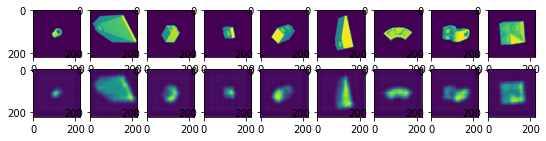

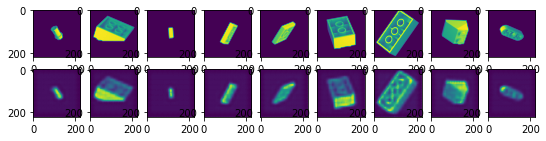

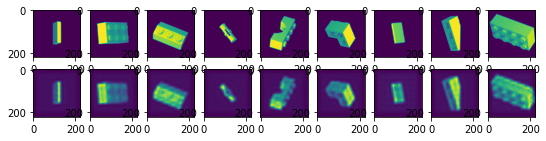

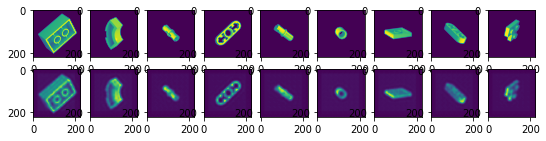

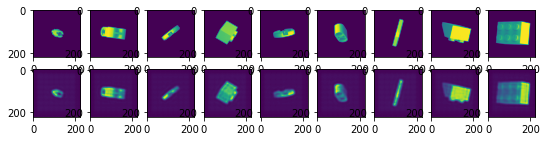

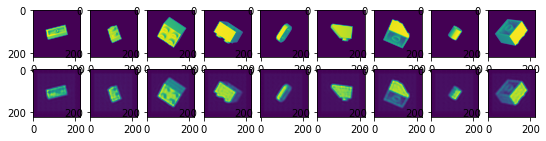

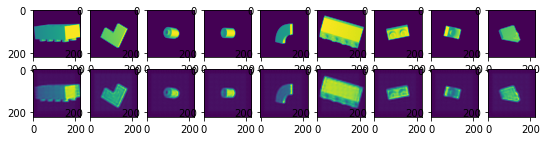

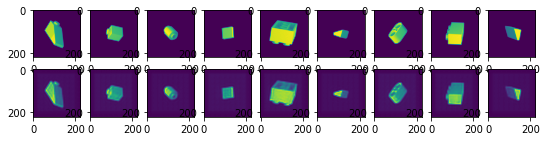

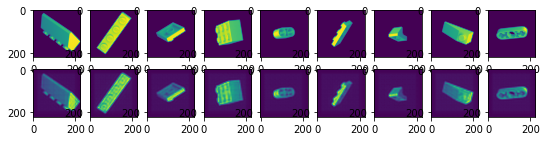

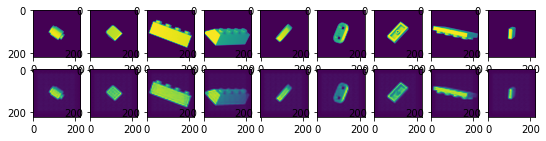

In [ ]:
for k in range(0, max_epochs, 2):
    plt.figure(figsize=(9, 2))
    imgs = outputs_noise[k][1].detach().cpu().numpy()
    recon = outputs_noise[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [ ]:
torch.save(model_2.state_dict(), os.path.expanduser('~/models/AutoEncoder/medium_noise_1e4.pt'))

# Medium Autoencoder + classifier

In [11]:
loaded_model_medium = AutoencoderMedium().cuda()
loaded_model_medium.load_state_dict(torch.load(os.path.expanduser('~/models/AutoEncoder/medium_noise_1e4.pt')))
loaded_model_medium.eval()

AutoencoderMedium(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): Sigmoid()
  )
)

In [12]:
# turn off gradient just to be safe
for l in loaded_model_medium.encoder:
  for p in l.parameters():
    p.requires_grad = False

In [13]:
# verify that the parameters are loaded correctly
train_loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size,
                                             num_workers = 4, shuffle = True)
criterion = nn.MSELoss()
for data in train_loader:
  img, _ = data
  if torch.cuda.is_available():
    img = img.cuda()
  recon = loaded_model_medium(img)
  loss = criterion(recon, img)
  print(loss)
  break

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward>)


In [ ]:
class AutoEncoderClassifierMedium(nn.Module):
  def __init__(self):
    super(AutoEncoderClassifierMedium, self).__init__()
    self.name = "AutoEncoderClassifierMedium"
    self.fc1 = nn.Linear(256*10*10, 256*20)
    self.fc2 = nn.Linear(256*20, 256*8)
    self.fc3 = nn.Linear(256*8, 256)
    self.fc4 = nn.Linear(256, 50)
  
  def forward(self, x):
    x = x.view(-1, 256*10*10)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = F.leaky_relu(self.fc3(x))
    x = self.fc4(x)
    return x

AECNet = AutoEncoderClassifierMedium()
summary(AECNet, (256,10,10), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 5120]     131,077,120
            Linear-2                 [-1, 2048]      10,487,808
            Linear-3                  [-1, 256]         524,544
            Linear-4                   [-1, 50]          12,850
Total params: 142,102,322
Trainable params: 142,102,322
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.06
Params size (MB): 542.08
Estimated Total Size (MB): 542.23
----------------------------------------------------------------


In [17]:
# training with the initial set up
use_cuda = True
AECNet = AutoEncoderClassifierMedium().cuda()
autoencoder_classifier_train(AECNet, loaded_model_medium, batch_size=500, num_epochs=100, lr=0.001)

Epoch 0 Finished.  Time per Epoch:  101.15 s 
train err: 0.9576, train loss: 418.2924
validation err: 0.9170, validation loss: 54.1857
Epoch 1 Finished.  Time per Epoch:  100.50 s 
train err: 0.8529, train loss: 139.3394
validation err: 0.8094, validation loss: 42.5460
Epoch 2 Finished.  Time per Epoch:  100.72 s 
train err: 0.7689, train loss: 117.5060
validation err: 0.7260, validation loss: 37.4540
Epoch 3 Finished.  Time per Epoch:  100.06 s 
train err: 0.7178, train loss: 107.4284
validation err: 0.7070, validation loss: 35.0526
Epoch 4 Finished.  Time per Epoch:  98.25 s 
train err: 0.6712, train loss: 99.5317
validation err: 0.6886, validation loss: 33.0766
Epoch 5 Finished.  Time per Epoch:  97.05 s 
train err: 0.6410, train loss: 94.5359
validation err: 0.6441, validation loss: 31.4487
Epoch 6 Finished.  Time per Epoch:  96.27 s 
train err: 0.6304, train loss: 92.5806
validation err: 0.6351, validation loss: 31.1614
Epoch 7 Finished.  Time per Epoch:  95.62 s 
train err: 0.592

KeyboardInterrupt: ignored

In [19]:
plot_training_curve(get_model_name(AECNet.name, 500, 0.001, 30))

OSError: ignored

# With drop out

In [15]:
class AutoEncoderClassifierMediumDrop(nn.Module):
  def __init__(self, p=0.0):
    super(AutoEncoderClassifierMediumDrop, self).__init__()
    self.name = "AutoEncoderClassifierMedium"
    self.fc1 = nn.Linear(256*10*10, 256*20)
    self.fc2 = nn.Linear(256*20, 256*8)
    self.fc3 = nn.Linear(256*8, 256)
    self.fc4 = nn.Linear(256, 50)
    self.dropout = nn.Dropout(p=p)
  
  def forward(self, x):
    x = x.view(-1, 256*10*10)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = F.leaky_relu(self.fc3(x))
    x = self.fc4(x)
    x = self.dropout(x)
    return x

AECNetMedDrop = AutoEncoderClassifierMediumDrop()
summary(AECNetMedDrop, (256,10,10), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 5120]     131,077,120
            Linear-2                 [-1, 2048]      10,487,808
            Linear-3                  [-1, 256]         524,544
            Linear-4                   [-1, 50]          12,850
           Dropout-5                   [-1, 50]               0
Total params: 142,102,322
Trainable params: 142,102,322
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.06
Params size (MB): 542.08
Estimated Total Size (MB): 542.23
----------------------------------------------------------------


In [18]:
# training with the initial set up
use_cuda = True
AECNetMedDrop = AutoEncoderClassifierMediumDrop(0).cuda()
autoencoder_classifier_train(AECNetMedDrop, loaded_model_medium, batch_size=500, num_epochs=50, lr=0.002)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f32d9c46a20>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f32d9c46a20>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f32d9c46a20>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f32d9c46a20>>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
  Fi

Epoch 0 Finished.  Time per Epoch:  84.85 s 
train err: 0.9770, train loss: 1983.8401
validation err: 0.9467, validation loss: 61.5087
Epoch 1 Finished.  Time per Epoch:  85.15 s 
train err: 0.9493, train loss: 171.3540
validation err: 0.9247, validation loss: 52.7418
Epoch 2 Finished.  Time per Epoch:  85.07 s 
train err: 0.9227, train loss: 153.1937
validation err: 0.9325, validation loss: 53.0431
Epoch 3 Finished.  Time per Epoch:  84.96 s 
train err: 0.8913, train loss: 143.1905
validation err: 0.8508, validation loss: 45.0158
Epoch 4 Finished.  Time per Epoch:  84.92 s 
train err: 0.8545, train loss: 132.1352
validation err: 0.8395, validation loss: 43.0975
Epoch 5 Finished.  Time per Epoch:  84.89 s 
train err: 0.8067, train loss: 122.6523
validation err: 0.7800, validation loss: 39.7596
Epoch 6 Finished.  Time per Epoch:  84.82 s 
train err: 0.7870, train loss: 119.2878
validation err: 0.8116, validation loss: 40.8805
Epoch 7 Finished.  Time per Epoch:  84.76 s 
train err: 0.776

UnboundLocalError: ignored

In [19]:
plot_training_curve(get_model_name(AECNetMedDrop.name, 500, 0.001, 49))

OSError: ignored